# Exposed and Infected class calculations

This notebook implements methods to calculate exposed and infected classes based on death and confirmed case numbers

In [5]:
import pandas as pd
import numpy as np
from scipy.stats.distributions import gamma
import matplotlib.pyplot as plt


In [55]:
def normalize_jh_data(jh,name):
    jh['Country/Region'] = jh[['Country/Region','Province/State']].replace(np.nan,''""'').agg(' - '.join, axis=1).str.strip('- ')
    jh = jh.drop(columns=['Province/State','Lat','Long'])
    jh = jh.melt(id_vars=['Country/Region'],value_name=name)
    jh['variable'] = pd.to_datetime(jh['variable'])
    return jh

jhcc = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
jhd = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')


jhcc, jhd = normalize_jh_data(jhcc,'Confirmed'), normalize_jh_data(jhd,'Deaths')

out = jhd.set_index(['Country/Region','variable']).join(jhcc.set_index(['Country/Region','variable']))
out = out.loc[~out.index.duplicated()]

This is the infection to death distribution from the [ICL Paper](https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-30-COVID19-Report-13.pdf)

IFR is from [Wu et. al](https://www.nature.com/articles/s41591-020-0822-7) w/25% asymptomatic

In [57]:
ICL_STD = gamma(1/0.45**2,0,18.8*0.45**2)
ICL_ITS = gamma(1/0.86**2,0,5.1*0.86**2)

DEATHS_DAYS_S = np.array([ICL_STD.cdf(a+1)-ICL_STD.cdf(a) for a in range(100)])
S_DAYS = np.array([ICL_ITS.cdf(a+1)-ICL_ITS.cdf(a) for a in range(60)])

DEATHS_DAYS = np.convolve(DEATHS_DAYS_S,S_DAYS)

In [58]:
# see heading "Align Confirmed Cases" below

def transformCases(s,shift=-7):
    shifted = s.diff().shift(shift)
    return shifted


# This isn't very accurate, and a better nowcast might be useful.
# However, wherever we use it we then take a convolutions with a distributions with 
# very small weight on the relevant days, and it's probably not orders of magnitude out
# which an exponential fit can be

def fillforward(orig,fill=7, pred=7):
    s = orig.copy()
    data_x = np.linspace(1,pred,pred)
    data_pred = np.linspace(pred+1,pred+1+fill,fill)
    try:
        s[-fill:] = np.poly1d(np.polyfit(data_x,
                                       s[-(pred+fill):-fill],1))(data_pred)
    except ValueError:
        print('Invalid data for linear fit', s[-(pred+fill):-fill])
        # In this case, we really don't know what cases are likely to do
        s[-fill:] = np.nan
        return s
    return s

# see heading "Comparison of Expected Deaths" below


def expectedDeaths(s,fatality=0.008,shift=7):
    s_pad = np.pad(s,(len(DEATHS_DAYS)-2,0),constant_values=0)
    cv = np.convolve(fillforward(s_pad,fill=shift),DEATHS_DAYS,'valid')
    pw = len(s)-len(cv)
    return fatality*np.pad(cv,(pw,0),"constant",constant_values=np.nan)

## see heading "Recovered, Infectious and Exposed Classes" below


def lik_r(i,mu=0.5):
    return np.exp(-mu*i)

norm = lik_r(np.arange(1,100)).sum()

def r(i):
    return lik_r(i)/norm

def R(ti):
    ti_pad = np.pad(ti,(40,0),'constant',constant_values=0)
    cv = np.convolve(ti_pad,r(np.arange(1,42)),'valid')
    pw = len(ti)-len(cv)
    return np.pad(cv,(pw,0),"constant",constant_values=0)

norm_I = lik_r(np.arange(1,100),0.2).sum()

def inf(i):
    return lik_r(i,0.2)/norm_I

def E2I(new_exposed):
    ne_pad = np.pad(new_exposed,(40,0),'constant',constant_values=0)
    cv = np.convolve(ne_pad,inf(np.arange(1,42)),'valid')
    pw = len(new_exposed)-len(cv)
    return np.pad(cv,(pw,0),"constant",constant_values=0)

# Calculate ascertainment, true infection rates, exposed and infectious classes and add as new columns
# Returns a much smaller dataframe, as 

def filtered_mean(m,indices):
    return m[indices].mean()

def ascertainment(csse_ds,fatality = 0.008,shift=7):
    csse_df = csse_ds.copy()
    csse_df['New confirmed shifted'] = csse_df['Confirmed'].groupby(level=0).transform(transformCases,shift=-1*shift)
    csse_df['New deaths'] = csse_df['Deaths'].groupby(level=0).transform(lambda x: x.diff())
    
    g = csse_df.groupby(level=0)
    
    csse_df['Expected deaths'] = g['New confirmed shifted'].transform(expectedDeaths,fatality=fatality,shift=shift)
    
    deaths = csse_df['New deaths']>=10
    #last2 = csse_df.index.get_level_values(1)>= csse_df.index.get_level_values(1).max() - pd.Timedelta(days=14)
    
    indices = deaths# & last2
    
    csse_df['Ascertainment'] = np.nan
    
    csse_df.loc[indices,'Ascertainment'] = pd.to_numeric(csse_df.loc[indices,'Expected deaths']
                                            /csse_df.loc[indices,'New deaths'])
    
    csse_df['New cases true'] = (csse_df['New confirmed shifted']
                                             /csse_df.groupby(level=0)['Ascertainment'].transform(filtered_mean,indices))

    g2 = csse_df.groupby(level=0)
    ever_exposed = g2['New cases true'].transform(np.cumsum)
    new_post_exposed= g2['New cases true'].transform(lambda x: E2I(x))
    post_exposed = new_post_exposed.groupby(level=0).transform(np.cumsum)
    csse_df['Exposed'] = ever_exposed - post_exposed
    csse_df['Recovered'] = new_post_exposed.groupby(level=0).transform(lambda x: np.cumsum(R(x)))
    csse_df['Infectious'] = post_exposed - csse_df['Recovered']
    return csse_df

def window_sum(a, n=3) :
    ret = a.cumsum()
    ret2 = a.shift(n).cumsum()
    return (ret-ret2)/n

## Align confirmed cases

The first step is to calculate new infections timeshifted back by 7 days. The figure 7 comes from:
 - 5.5 days infection-to-symptoms (https://docs.google.com/spreadsheets/d/1yzVSp71jiCsoD_L6sXchfg8L9OF0tGHWEnCdfvF73Ac/edit#gid=1242721729)
 - 4 days symptoms-to-confirmation (also https://docs.google.com/spreadsheets/d/1yzVSp71jiCsoD_L6sXchfg8L9OF0tGHWEnCdfvF73Ac/edit#gid=1242721729)
 - Subtract two days as exponential growth means that fast confirmations will be overrepresented
 
We could in principle calculate this properly as we do with time to death, but for the purposes of calculating the true number of cases it is less crucial than calculating infection to death properly.

There may also be a lag in the reporting of deaths. However, adding a lag produces unreasonable results, which may indicate that the above lag of 7 is too short.

In [77]:
csse_demo = out.copy()

csse_demo['New Confirmed Shifted'] = csse_demo['Confirmed'].groupby(level=0).transform(transformCases,shift=-7)
csse_demo['New Deaths'] = csse_demo['Deaths'].groupby(level=0).transform(transformCases,shift=-0)

csse_demo.loc['Italy'][-10:]

,Deaths,Confirmed,New Confirmed Shifted,New Deaths
variable,,,,
2020-04-12,19899,156363,3047.0,431.0
2020-04-13,20465,159516,2256.0,566.0
2020-04-14,21067,162488,2729.0,602.0
2020-04-15,21645,165155,NaN,578.0
2020-04-16,22170,168941,NaN,525.0
2020-04-17,22745,172434,NaN,575.0
2020-04-18,23227,175925,NaN,482.0
2020-04-19,23660,178972,NaN,433.0
2020-04-20,24114,181228,NaN,454.0


## Comparison of Expected Deaths

The number of deaths on day $i$ should be
$$ d_i = f \sum_j p_{i-j} t_j $$
where $f$ is the infection fatality rate, $p_k$ is the probability of dieing $k$ days after being infected and $t_j$ is the true number of cases on day $j$.

Suppose that there is a fixed ascertainment rate $a$ such that confirmed cases $c_j=a t_{j-7}$ for all $j$. Then 

$$ a = \frac{f\sum_j p_{i-j} c_{j+7}}{d_{i}} $$

**Note** This is actually *lagged* ascertainment rate - it asks "what fraction of new cases today are detected 7 days later". I don't directly estimate an instantaneous ascertainment rate as this is very sensitive to the short term trajectory of infections, which, as I note above, I can't yet forecast. What we can in fact calculate is:

$$ t_{i-7} = \frac{c_i}{a}  $$

In [79]:
g = csse_demo.groupby(level=0)

csse_demo['Expdeaths'] = g['New Confirmed Shifted'].transform(expectedDeaths,fatality=0.008)
csse_demo['Ascertainment'] = csse_demo['Expdeaths']/csse_demo['New Deaths']

To compare this to [ICL Report 13](https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-30-COVID19-Report-13.pdf), we take the average ascertainment estimate for the UK

In [62]:
csse_demo.index.get_level_values(0)[csse_demo.index.get_level_values(0).str.startswith('U')].unique()

Index(['Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom - Bermuda',
       'United Kingdom - Cayman Islands', 'United Kingdom - Channel Islands',
       'United Kingdom - Gibraltar', 'United Kingdom - Isle of Man',
       'United Kingdom - Montserrat', 'United Kingdom', 'Uruguay', 'US',
       'Uzbekistan', 'United Kingdom - Anguilla',
       'United Kingdom - British Virgin Islands',
       'United Kingdom - Turks and Caicos Islands',
       'United Kingdom - Falkland Islands (Malvinas)'],
      dtype='object', name='Country/Region')

In [63]:
csse_demo.loc['United Kingdom','Ascertainment'][-20:].mean()

0.025811814373481463

Given the lag we include, the number of cases in existence on March 28th is the number of cases detected on April 4th. The ICL report also uses an IFR of around 1 vs the 0.8 we used to calculate this table. So, estimated percentage who have ever been infected as of March 28th is
$$\text{Cumulative infections} = \frac{IFR_{ICL}}{IFR_{nb}}\cdot\frac{\text{confirmed cases on April 4th}}{\text{Average ascertainment}}\cdot\frac{1}{\text{UK population}}$$

In [64]:
1./0.8*41903/0.0258/66e6

0.03076036528071412

This is rather similar to their central estimate of 2.7% infected, which is probably to be expected given that we use their infection-to-death distribution

This method suggests that ascertainment in Italy has been rising substantially. In fact, I suspect this indicates I haven't calibrated the timings properly.

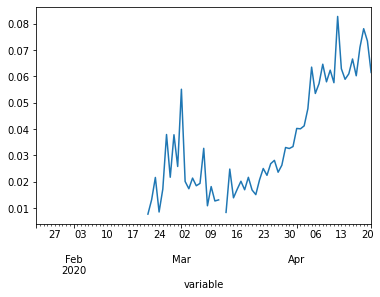

In [80]:
csse_demo.loc['Italy','Ascertainment'].plot()

Ascertainment in Brazil looks to be gradually rising.

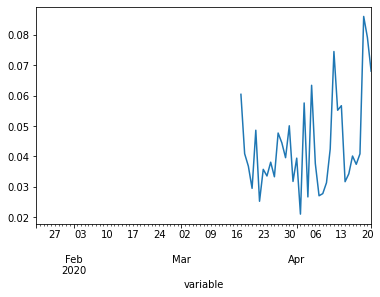

In [81]:
csse_demo.loc['Brazil','Ascertainment'].replace(np.inf,np.nan).plot()

# Filter out small numbers of deaths

The method doesn't work well with small numbers of deaths per day. Fully Bayesian treatment probably handles this case better, or even variance weighted averaging. However, for now I just remove days with small numbers of new deaths from consideration.

## Recovered, Infectious and Exposed Classes

The infectious class is given by 

$$ I_i = \sum_{j} q_{i-j} t_j - \sum_{j} r_{i-j} t_j $$

and the exposed class by 

$$ E_i = \sum_j (1-q_{i-j}) t_j $$

finally, the recovered class is given by

$$ R_i = \sum_j r_{i-j} t_j $$

Where $q_n$ is the distribution of the time from being exposed to being infectious, $E_i$ and $I_i$ the size of the exposed and infected classes on day $i$ and $t_j$ the true number of new cases on day $j$ as above

To make the infectious class match [GLEAM's treatment](http://www.gleamviz.org/simulator/models/), we take $q_{i-j}=A e^{-(i-j)\epsilon}$ where $A$ is some normalising constant. That is, the transition probability is an exponential. Currently we use $\epsilon=0.2$.

To get a recovery rate that matches our use of GLEAM, we could take $r_i = B e^{-i\mu}$ where $\mu=0.5$ is the rate of recovery from GLEAM and $B$ is a normalising constant. This is a bit unrealistic, but alternative approaches are tricky to implement.

Another possibility is to take the "serial interval" distribution from https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-30-COVID19-Report-13.pdf (note that this seems to be the distribution of probability of infection, not probability of first infection, so it's not acutally the serial interval). However, we need to turn this nonexponential distribution into an exponential infectious class, and figuring out how to approximate this appropriately seems hard.

In [82]:
# Just calculate everything


low = ascertainment(out,0.003,shift=7)
mid = ascertainment(out,0.008,shift=7)
high = ascertainment(out,0.015,shift=7)

In [161]:
# Some estimates for Italy
mid.loc['Austria'][-34:-21].sum(0)

Deaths                      488.000000
Confirmed                 69031.000000
New confirmed shifted      7014.000000
New deaths                  105.000000
Expected deaths              15.044855
Ascertainment                 0.486179
New cases true            38189.379673
Exposed                  184169.748783
Recovered                442499.119638
Infectious                62112.039213
dtype: float64

In [168]:
2607/(83500+686156+29985)

0.003260213020592991

In [182]:
mid.loc['Sweden'][-36:-22].sum(0)

Deaths                      611.000000
Confirmed                 30261.000000
New confirmed shifted      4896.000000
New deaths                  107.000000
Expected deaths               7.492416
Ascertainment                 0.152426
New cases true            93092.600207
Exposed                  319440.105485
Recovered                691626.385726
Infectious                97374.322036
dtype: float64

In [163]:
low.loc['Brazil'][-10:-6]

,Deaths,Confirmed,New confirmed shifted,New deaths,Expected deaths,Ascertainment,New cases true,Exposed,Recovered,Infectious
variable,,,,,,,,,,
2020-04-11,1124,20727,2976.0,67.0,1.871315,0.027930,183604.979265,620640.240816,1.454001e+06,186982.425607
2020-04-12,1223,22192,1996.0,99.0,2.047643,0.020683,123143.662168,608958.830718,1.580622e+06,195186.113985
2020-04-13,1328,23430,2089.0,105.0,2.230902,0.021247,128881.317770,604092.514495,1.710047e+06,199508.403164
2020-04-14,1532,25262,NaN,204.0,2.421707,0.011871,NaN,NaN,NaN,NaN


In [164]:
high.loc['Brazil'][-8:-6]

,Deaths,Confirmed,New confirmed shifted,New deaths,Expected deaths,Ascertainment,New cases true,Exposed,Recovered,Infectious
variable,,,,,,,,,,
2020-04-13,1328,23430,2089.0,105.0,11.154509,0.106233,25776.263554,120818.502899,342009.498605,39901.680633
2020-04-14,1532,25262,NaN,204.0,12.108535,0.059356,NaN,NaN,NaN,NaN


In [78]:
# Some estimates for UK
mid.loc['Germany'][-20:]

,Deaths,Confirmed,New confirmed shifted,New deaths,Expected deaths,Ascertainment,New cases true,Exposed,Recovered,Infectious
variable,,,,,,,,,,
2020-04-01,920,77872,5633.0,145.0,19.543398,0.134782,31205.549984,122399.356038,463181.620934,42031.160217
2020-04-02,1107,84794,4885.0,187.0,21.284991,0.113823,27061.798628,122368.455553,490379.740263,41925.740002
2020-04-03,1275,91159,3990.0,168.0,22.997264,0.136888,22103.700415,118283.817430,517180.541809,41313.276992
2020-04-04,1444,96092,2737.0,169.0,24.655472,0.145890,15162.362916,109256.526166,542953.936925,39729.536057
2020-04-05,1584,100123,2946.0,140.0,26.237244,0.187409,16320.175795,102813.550192,567542.893576,37903.731175
2020-04-06,1810,103374,2218.0,226.0,27.722385,0.122665,12287.219930,94236.592827,590666.263751,35644.538294
2020-04-07,2016,107663,1287.0,206.0,29.092363,0.141225,7129.689833,82991.763765,611921.106546,32764.214395
2020-04-08,2349,113296,3394.0,333.0,30.329775,0.091080,18801.994789,83341.812093,632073.095569,31064.171832
2020-04-09,2607,118181,2945.0,258.0,31.418301,0.121776,16314.636020,81591.982151,651403.708271,29798.025093


In [74]:
mid.loc['AU-NSW']

,Recovered,Confirmed,Deaths,Active,New confirmed shifted,New deaths,Expected deaths,Ascertainment,New cases true,Exposed,Infectious
Date,,,,,,,,,,,
2020-01-22 00:00:00+00:00,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23 00:00:00+00:00,NaN,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN
2020-01-24 00:00:00+00:00,NaN,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN
2020-01-25 00:00:00+00:00,NaN,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN
2020-01-26 00:00:00+00:00,NaN,3.0,0.0,3.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-12 00:00:00+00:00,NaN,2857.0,24.0,2829.0,NaN,1.0,0.984995,NaN,NaN,NaN,NaN
2020-04-13 00:00:00+00:00,NaN,2863.0,25.0,2834.0,NaN,1.0,0.961706,NaN,NaN,NaN,NaN
2020-04-14 00:00:00+00:00,NaN,2870.0,25.0,2841.0,NaN,0.0,0.932404,NaN,NaN,NaN,NaN


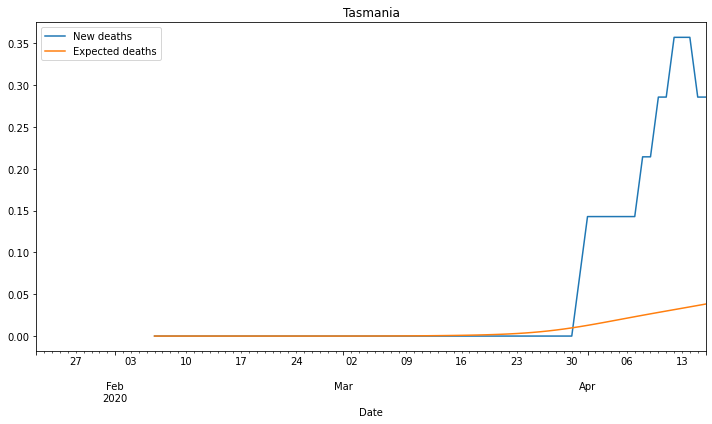

In [103]:
tas = window_sum(mid.loc[mid.index.get_level_values(0).str.startswith('AU-TAS'),['New deaths','Expected deaths']],n=14)
# plt.plot(tas[-16:,1]/tas[-16:,0]
fig,ax = plt.subplots(figsize=(10,6))
tas.loc['AU-TAS'].plot(ax=ax)
ax.set_title('Tasmania')
plt.tight_layout()
plt.savefig('tas_expdeaths.png')

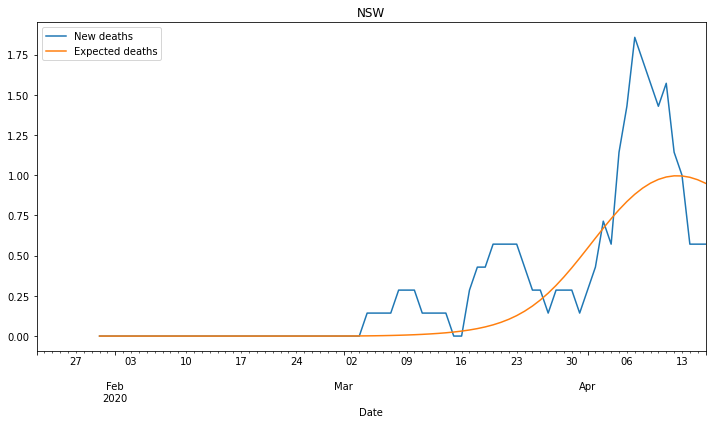

In [104]:
nsw = window_sum(mid.loc[mid.index.get_level_values(0).str.startswith('AU-NSW'),['New deaths','Expected deaths']],n=7)
# plt.plot(tas[-16:,1]/tas[-16:,0]
# nsw = nsw.rename(columns={'New deaths':'New deaths, 7 day moving average','Expected deaths':'Expected deaths from confirmed cases'})
fig,ax = plt.subplots(figsize=(10,6))
nsw.loc['AU-NSW'].plot(ax=ax)
ax.set_title('NSW')
plt.tight_layout()
plt.savefig('nsw_expdeaths.png')

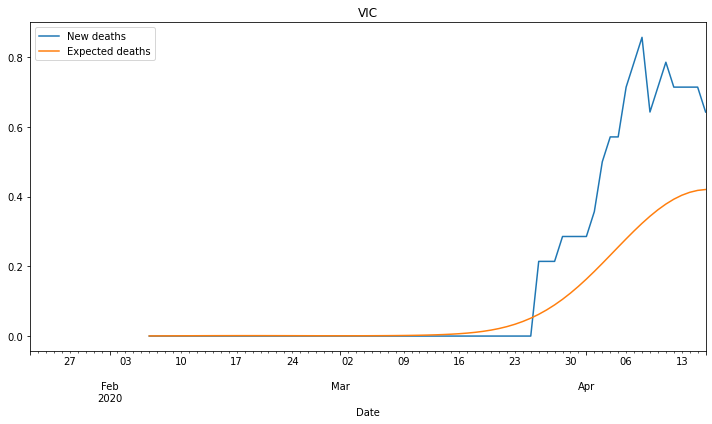

In [105]:
vic = window_sum(mid.loc[mid.index.get_level_values(0).str.startswith('AU-VIC'),['New deaths','Expected deaths']],n=14)
# plt.plot(tas[-16:,1]/tas[-16:,0]
fig,ax = plt.subplots(figsize=(10,6))
vic.loc['AU-VIC'].plot(ax=ax)
ax.set_title('VIC')
plt.tight_layout()
plt.savefig('vic_expdeaths.png')

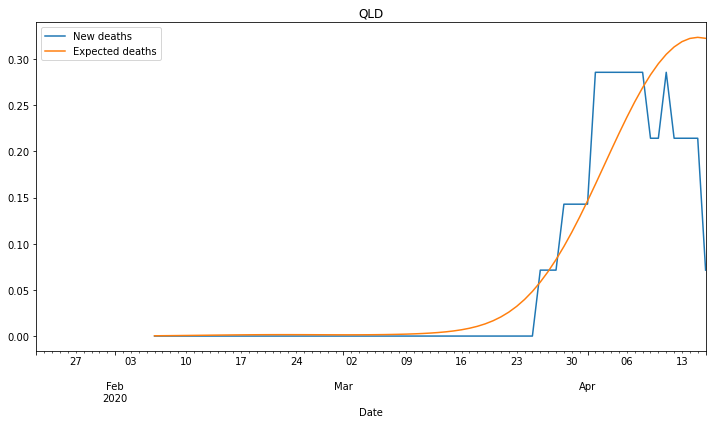

In [106]:
qld = window_sum(mid.loc[mid.index.get_level_values(0).str.startswith('AU-QLD'),['New deaths','Expected deaths']],n=14)
# plt.plot(tas[-16:,1]/tas[-16:,0]
fig,ax = plt.subplots(figsize=(10,6))
qld.loc['AU-QLD'].plot(ax=ax)
ax.set_title('QLD')
plt.tight_layout()
plt.savefig('qld_expdeaths.png')

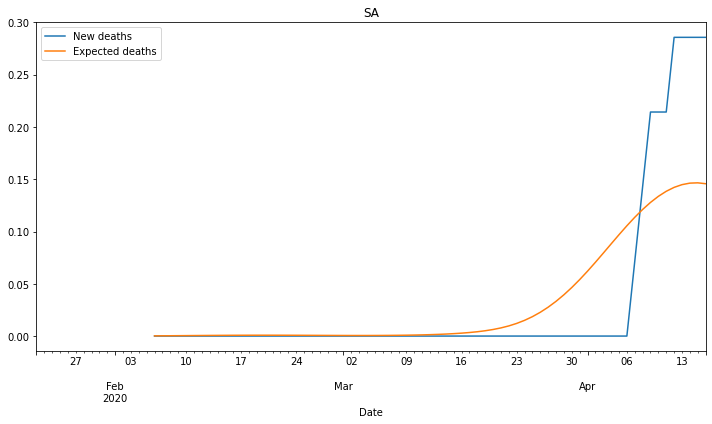

In [107]:
sa = window_sum(mid.loc[mid.index.get_level_values(0).str.startswith('AU-SA'),['New deaths','Expected deaths']],n=14)
# plt.plot(tas[-16:,1]/tas[-16:,0]
fig,ax = plt.subplots(figsize=(10,6))
sa.loc['AU-SA'].plot(ax=ax)
ax.set_title('SA')
plt.tight_layout()
plt.savefig('sa_expdeaths.png')

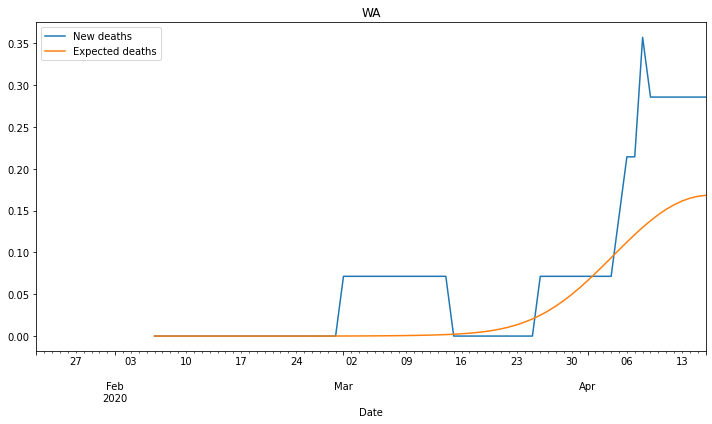

In [108]:
wa = window_sum(mid.loc[mid.index.get_level_values(0).str.startswith('AU-WA'),['New deaths','Expected deaths']],n=14)
# plt.plot(tas[-16:,1]/tas[-16:,0]
fig,ax = plt.subplots(figsize=(10,6))
wa.loc['AU-WA'].plot(ax=ax)
ax.set_title('WA')
plt.tight_layout()
plt.savefig('wa_expdeaths.png')

/home/guest/.cache/pypoetry/virtualenvs/epimodel-98U75rOO-py3.7/lib64/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/guest/.cache/pypoetry/virtualenvs/epimodel-98U75rOO-py3.7/lib64/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/guest/.cache/pypoetry/virtualenvs/epimodel-98U75rOO-py3.7/lib64/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/guest/.cache/pypoetry/virtualenvs/epimodel-98U75rOO-py3.7/lib64/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/guest/.cache/pypoetry/virtualenvs/epimodel-98U75rOO-py3.7/lib64/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is s

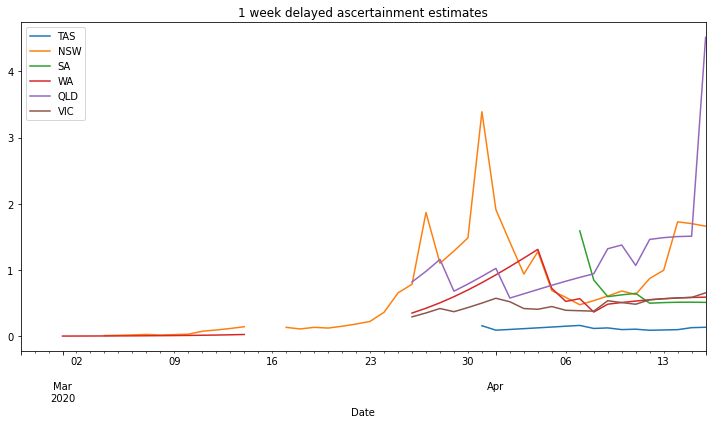

In [68]:
tas['TAS'] = tas['Expected deaths'].values/tas['New deaths'].values
tas['NSW'] = nsw['Expected deaths'].values/nsw['New deaths'].values
tas['SA'] = sa['Expected deaths'].values/sa['New deaths'].values
tas['WA'] = wa['Expected deaths'].values/wa['New deaths'].values
tas['QLD'] = qld['Expected deaths'].values/qld['New deaths'].values
tas['VIC'] = vic['Expected deaths'].values/vic['New deaths'].values
fig,ax = plt.subplots(figsize=(10,6))

tas.loc['AU-TAS',['TAS','NSW','SA','WA','QLD','VIC']][-50:].plot(ax=ax)
ax.set_title('1 week delayed ascertainment estimates')
plt.tight_layout()
plt.savefig('Ascertainment.png')

In [98]:
nsw['Expected deaths'].sum()/nsw['New deaths'].sum()

0.6995824711202663

In [99]:
qld['Expected deaths'].sum()/qld['New deaths'].sum()

1.1276195845248644

In [100]:
vic['Expected deaths'].sum()/vic['New deaths'].sum()

0.5060945422222791

# Some really dodgy curve fitting

To see if there's a viable simple approximation for the infectious class

In [440]:
# def approx(df,lag,window,col='Deaths',ifr=0.008):
#     return df.groupby(level=0)[col].diff(window).transform(lambda x: x*np.minimum(x/x.shift(int(lag)),10)/ifr).replace(np.inf,np.nan)

def approx(df,lag,fit,col='New deaths',ifr=0.008):
    return df.groupby(level=0)[col].transform(lambda x: x*np.minimum((x/x.shift(fit))**(lag/fit),5)/ifr).replace(np.inf,np.nan)
    

def mse(s,t):
    t = t.replace(0,1)
    return ((s-t)/t).mean(), np.abs((s-t)/t).mean(), np.sqrt(((s-t)**2).mean())

INDICES = ((mid.index.get_level_values(1)>pd.Timestamp('2020-03-15').tz_localize('UTC'))
           &
          (mid.index.get_level_values(0)!='CN-HB')
           &
          (mid['Deaths']>10))

In [441]:
for l in range(3,25):
    for f in range(2,10):
        ap = approx(mid,l,f,col='New deaths')[INDICES]
        mi = mid[INDICES]
        print(l,f,mse(ap,mi['Infectious']))

3 2 (-0.40020161389367276, 0.6921701282880028, 34585.20997122468)
3 3 (-0.44855197742668534, 0.6902619708945762, 34429.55886680074)
3 4 (-0.43877265024856016, 0.670908423885643, 33542.92237510516)
3 5 (-0.44877801708363424, 0.644461957202096, 33027.42556993997)
3 6 (-0.4259729057596157, 0.6500900461320298, 32775.17585323477)
3 7 (-0.41367594296320576, 0.6124347952534281, 32043.743415936024)
3 8 (-0.38489137912798704, 0.6163064004841599, 32696.96981467479)
3 9 (-0.34866049055738557, 0.6145055564847455, 33521.19367981753)
4 2 (-0.33426644756122537, 0.6917574405969505, 33303.86808177785)
4 3 (-0.3746159983418591, 0.6754786702782268, 32041.46191248084)
4 4 (-0.3726772310787621, 0.6706846931163126, 30489.019971216014)
4 5 (-0.3796839525620043, 0.6240050256201906, 30171.591262963295)
4 6 (-0.34915788552160076, 0.6295332383817994, 29311.69386561432)
4 7 (-0.34337519936477895, 0.5985243781110233, 29137.030818098418)
4 8 (-0.3206807264989836, 0.5918050003024152, 28905.21122120049)
4 9 (-0.29302

18 5 (-0.0464511700175593, 0.6643231847842628, 40285.480523763705)
18 6 (-0.12588408554046912, 0.7997093863131787, 39952.25504063164)
18 7 (0.003172184384793493, 0.667700991597665, 37430.77628780626)
18 8 (0.02239609008147311, 0.6553236475292077, 41884.831200701075)
18 9 (0.038156570330570135, 0.6699183674131621, 42334.64321269348)
19 2 (-0.1070457907728903, 0.758096580070757, 43768.723112797656)
19 3 (-0.11044942004428197, 0.731075899600843, 40744.61589820393)
19 4 (-0.055744013190206464, 0.7181907681021434, 39943.72905304356)
19 5 (-0.04058895582128568, 0.6660496507650017, 40867.02431184719)
19 6 (0.008199931616670911, 0.6776923592360713, 39626.02103814026)
19 7 (0.007286731735752317, 0.6701887262905221, 38334.555275639956)
19 8 (0.028193788399990934, 0.6578296790450341, 42381.90862082358)
19 9 (0.04786488040223842, 0.6709304751743745, 43940.9943538086)
20 2 (-0.10723765356697641, 0.762499365210899, 44265.25623147428)
20 3 (-0.10756981324285825, 0.7322969814440163, 41217.352106313905

In [390]:
ap = approx(mid,15,col='New deaths')[INDICES]
mid.loc[INDICES,'Approx'] = ap

In [58]:
np.array([(1/1.15)**i for i in range(0,1000)]).sum()

7.666666666666671

In [59]:
np.array([(1/1.3)**i for i in range(0,1000)]).sum()

4.333333333333332

In [175]:
mid.loc['NG'][-20:-7]

,Recovered,Confirmed,Deaths,Active,New confirmed shifted,New deaths,Expected deaths,Ascertainment,New cases true,Exposed,Infectious
Date,,,,,,,,,,,
2020-03-27 00:00:00+00:00,NaN,70.0,1.0,66.0,26.0,0.0,0.029384,NaN,NaN,NaN,NaN
2020-03-28 00:00:00+00:00,NaN,89.0,1.0,85.0,4.0,0.0,0.034763,NaN,NaN,NaN,NaN
2020-03-29 00:00:00+00:00,NaN,111.0,1.0,107.0,18.0,0.0,0.040644,NaN,NaN,NaN,NaN
2020-03-30 00:00:00+00:00,NaN,131.0,2.0,121.0,6.0,1.0,0.046900,NaN,NaN,NaN,NaN
2020-03-31 00:00:00+00:00,NaN,135.0,2.0,125.0,16.0,0.0,0.053353,NaN,NaN,NaN,NaN
2020-04-01 00:00:00+00:00,NaN,174.0,2.0,163.0,22.0,0.0,0.059774,NaN,NaN,NaN,NaN
2020-04-02 00:00:00+00:00,NaN,184.0,2.0,162.0,12.0,0.0,0.066046,NaN,NaN,NaN,NaN
2020-04-03 00:00:00+00:00,NaN,210.0,4.0,181.0,17.0,2.0,0.072030,NaN,NaN,NaN,NaN
2020-04-04 00:00:00+00:00,NaN,214.0,4.0,185.0,13.0,0.0,0.077652,NaN,NaN,NaN,NaN


In [179]:
mid.loc['ET'][-20:-7]

,Recovered,Confirmed,Deaths,Active,New confirmed shifted,New deaths,Expected deaths,Ascertainment,New cases true,Exposed,Infectious
Date,,,,,,,,,,,
2020-03-27 00:00:00+00:00,NaN,16.0,0.0,16.0,6.0,0.0,0.006053,NaN,NaN,NaN,NaN
2020-03-28 00:00:00+00:00,NaN,16.0,0.0,15.0,3.0,0.0,0.006666,NaN,NaN,NaN,NaN
2020-03-29 00:00:00+00:00,NaN,21.0,0.0,20.0,5.0,0.0,0.007344,NaN,NaN,NaN,NaN
2020-03-30 00:00:00+00:00,NaN,23.0,0.0,19.0,1.0,0.0,0.008095,NaN,NaN,NaN,NaN
2020-03-31 00:00:00+00:00,NaN,26.0,0.0,24.0,8.0,0.0,0.008922,NaN,NaN,NaN,NaN
2020-04-01 00:00:00+00:00,NaN,29.0,0.0,27.0,3.0,0.0,0.009824,NaN,NaN,NaN,NaN
2020-04-02 00:00:00+00:00,NaN,29.0,0.0,26.0,1.0,0.0,0.010806,NaN,NaN,NaN,NaN
2020-04-03 00:00:00+00:00,NaN,35.0,0.0,32.0,9.0,0.0,0.011864,NaN,NaN,NaN,NaN
2020-04-04 00:00:00+00:00,NaN,38.0,0.0,34.0,4.0,0.0,0.012984,NaN,NaN,NaN,NaN


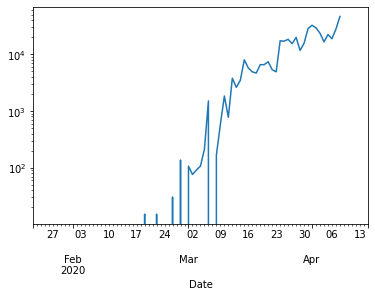

In [184]:
mid.loc['BR','New cases true'].plot(logy=True)

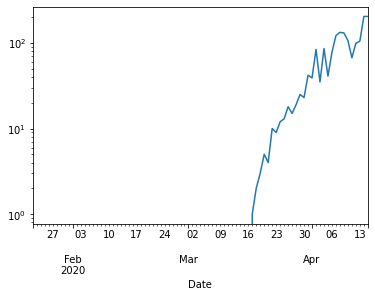

In [185]:
mid.loc['BR','New deaths'].plot(logy=True)

In [186]:
mid.loc['BR','Deaths']

Date
2020-01-22 00:00:00+00:00       0.0
2020-01-23 00:00:00+00:00       0.0
2020-01-24 00:00:00+00:00       0.0
2020-01-25 00:00:00+00:00       0.0
2020-01-26 00:00:00+00:00       0.0
                              ...  
2020-04-11 00:00:00+00:00    1124.0
2020-04-12 00:00:00+00:00    1223.0
2020-04-13 00:00:00+00:00    1328.0
2020-04-14 00:00:00+00:00    1532.0
2020-04-15 00:00:00+00:00    1736.0
Name: Deaths, Length: 85, dtype: float64